# SD212: Graph mining

## Project

### Title: Identifying the most profitable clubs in European Football

### Students: 
- Vincent Papegay-Vallet
- Clement Dussud
- Youssef Lahlou

The objective of this project is to learn how to extract useful information from graph data. 

Your task is the following:
* build your own graph from real data
* specify the problem(s) you would like to solve
* provide a solution
* visualize the results

## Instructions

In [1]:
name = 'Vincent_Papegay-Vallet_Clement_Dussud_Youssef_Lahlou'

You **must** use this name for the pickle file of your dataset and provide a link to this file:

In [2]:
# url to your dataset, to be modified
url = 'https://nextcloud.r2.enst.fr/nextcloud/index.php/s/4asMpoDkW7DddtM'

You must use the following name for your notebook:

In [3]:
# name of your notebook
name + '.ipynb'

'Vincent_Papegay-Vallet_Clement_Dussud_Youssef_Lahlou.ipynb'

## Data

In [4]:
import pickle

In [5]:
# you need to download data first (see the above url)
with open(name, 'br') as f:
    dataset = pickle.load(f)

Describe your data and how it has been collected (do not include the code used to extract data).

Our data regroups the tranfers incoming and out of the top 6 european football leagues (Premier League, Bundesliga, Liga, Ligue 1, Eredivise, Serie A) from 2009 to 2021. We collected it from a github which used webscraping data from Transfermarkt. We then crossed the data with another Kaggle repository to build a graph where the clubs are located in their origin country. We also split the data in two graphs in order to identify the transfer of young players (<25 y.o) and the global transfer list. 

The graph attributes are : 
- adjacency_total : Global adjacency matrix of transfers (weighted by transfer price)
- nodes_id_total : Global set of nodes id
- clubs_total : Dictionnary of clubs in the dataset with club id as key value
- country_total : Dictionnary of countries in the dataset with club id as key value
- clubs_id_total_1 : List of clubs in the dataset
- geo_total : localisation of the club in the world
- adjacency_young : Adjacency matrix of transfers for young players (weighted by transfer price)
- nodes_id_young : Set of nodes id in transfer of young players
- clubs_young :  Dictionnary of clubs in the dataset with club id as key value when restricted to young players
- country_young : Dictionnary of countries in the dataset with club id as key value when restricted to young players
- clubs_id_young_1 : List of clubs in the dataset when restricted to young players
- geo_young : localisation of the club in the world when restricted to young players

## Problem

Describe the problem you want to solve (be concise).

A common belief is that young football prodigees come from all around the globe to play football in the top european leagues, and often end up in the same top teams. We would like to test this hypothesis. In order to do so we will try to : 
- Identify the football clubs with the highest transfer profits.
- Determine whether or not South-American clubs generate a lot of benefits from transfers towards european clubs. 
- Identify which clubs have the most influence on the transfer market.  

## Solution

Describe your solution, including the code and a visualization of the results.

In [6]:
import numpy as np
import sknetwork as skn
from IPython.display import SVG
from sknetwork.visualization import svg_graph, svg_digraph, svg_bigraph
from sknetwork.regression import Dirichlet
from sknetwork.ranking import PageRank, top_k
from sknetwork.path import get_distances, get_diameter, get_shortest_path


# High profit transfers

In [7]:
adjacency_young = dataset.adjacency_young
adjacency = dataset.adjacency_total
geo = np.array(dataset.geo_total)
geo_young = np.array(dataset.geo_young)

In [8]:
total_sold = dataset.adjacency_young.T @ np.ones(dataset.adjacency_young.shape[0])

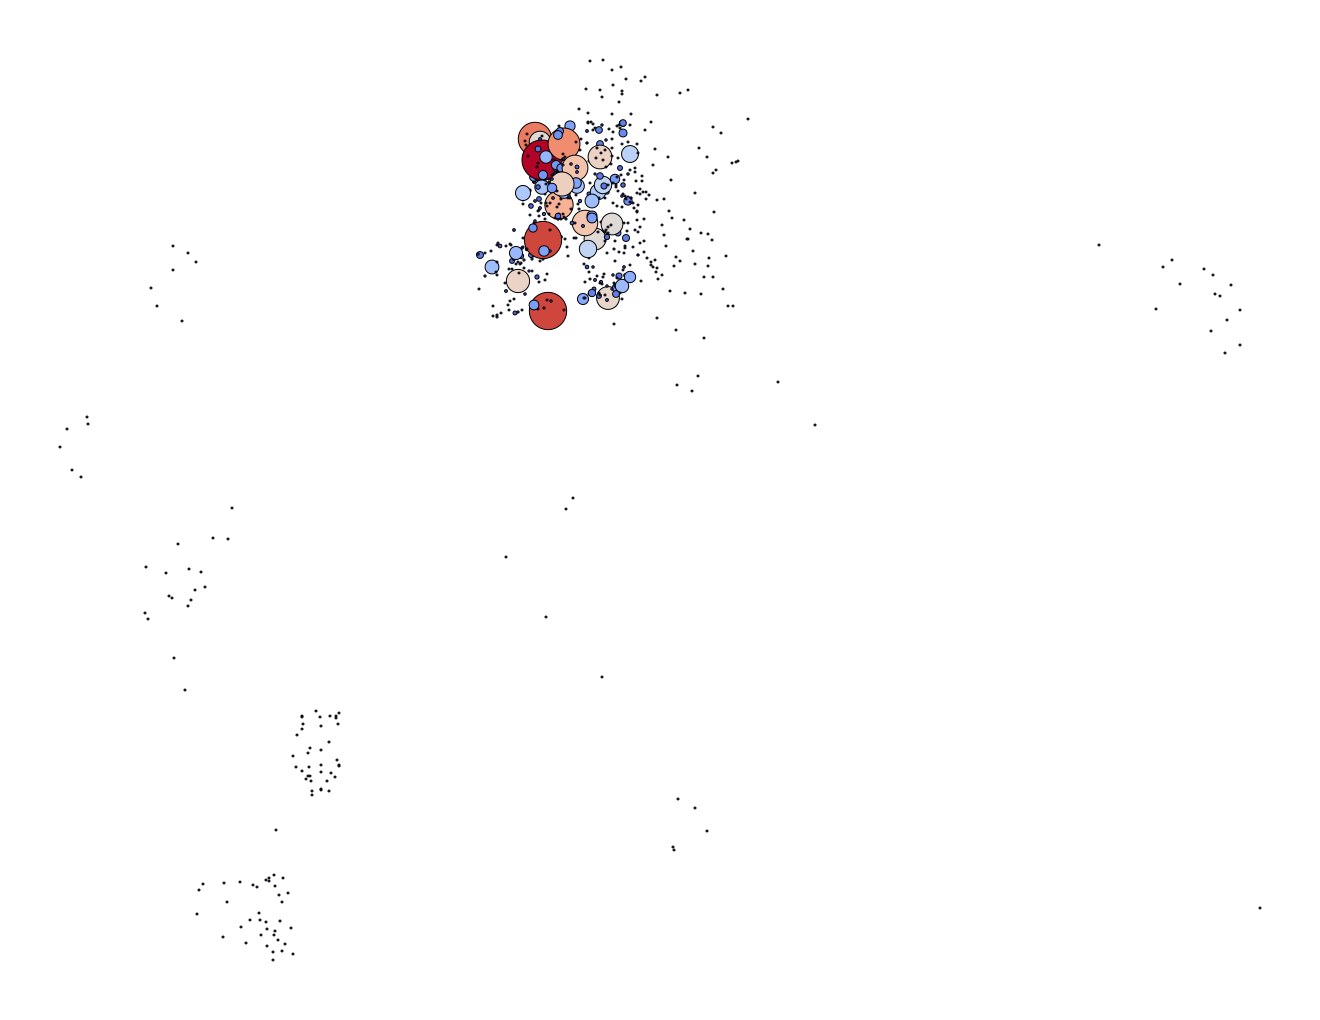

In [9]:
image = svg_graph(adjacency_young, position=geo_young, display_edges=False,display_edge_weight = False, directed=True, scale = 3, display_node_weight=True, edge_width=1, node_size_min=1, name_position='below',scores=total_sold)
SVG(image)

We can straight away visualise that contrary to a popular beliefs, highest profits (and therefore the best formation centers) tend to belong to european leagues. 

Basing ourselves on this observation, we are going to use a Heat diffusion algorithm to see if using metrics on the number of transfers could change the result. We will set a temperature equal to the number of player of less than 23 years old and leaving the club with a transfer valued at more than 5 million euros. 

For instance, if Liverpool FC has sold 3 players in this way, the temperature for this club will be 3. For all clubs not involved in such transfers, we are going to attribute them an initial temperature of 0.

In [10]:
final_seeds = {x:0 for x in range(0,len(dataset.nodes_id_total))}  
for transfer in dataset.clubs_id_young_1:
    tmp = dataset.clubs_total.get(f'{transfer}')
    tmp_index = list(dataset.nodes_id_total).index(f'{tmp}')
    final_seeds[tmp_index] += 1

## Heat Diffusion

In [11]:
dirichlet = Dirichlet()

In [12]:
temperatures = dirichlet.fit_transform(dataset.adjacency_total, final_seeds)

In [13]:
print(len(np.array(dataset.geo_total)))
print(dataset.adjacency_total.shape)

1064
(1064, 1064)


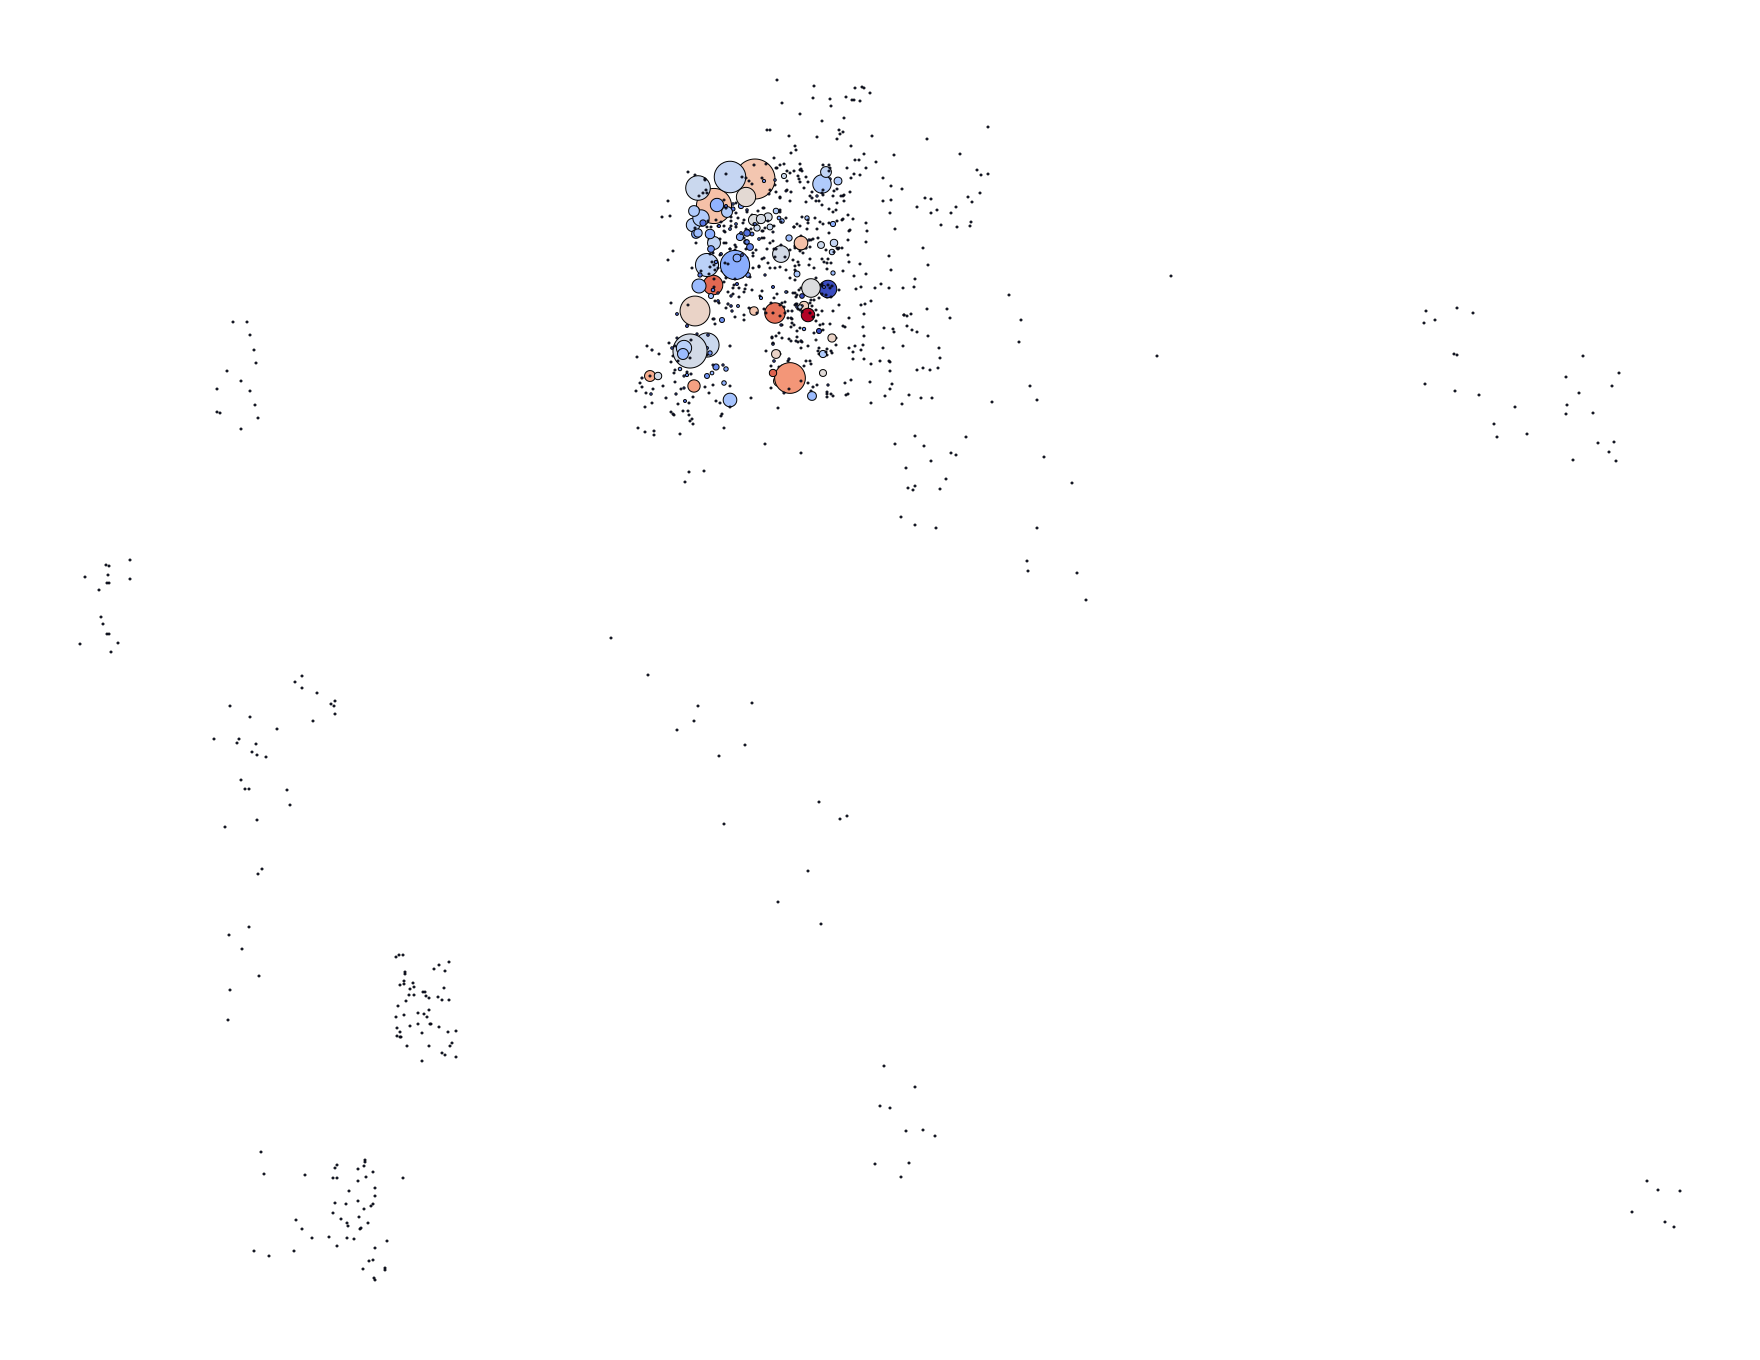

In [14]:
image = svg_graph(adjacency, position=geo, display_edges=False, display_edge_weight=False, directed=True, scale=4, display_node_weight=True, edge_width=1, node_size_min=1, name_position='below',scores=temperatures)
SVG(image)

In [15]:
list_scores = list(temperatures)
list_best_indexes = []
while (len(list_best_indexes)<=5):
    list_best_indexes.append(np.argmax(list_scores))
    list_scores.pop(np.argmax(list_scores))

In [16]:
best_club_names = []    
for x in list_best_indexes:
    best_club_names.append(dataset.nodes_id_total[x])
print(best_club_names)

['Genoa CFC', 'US Triestina', 'AS Monaco', 'AS Nancy-Lorraine U19', 'Jiangsu Suning', 'SK Sigma Olomouc']


## PageRank

In [17]:
pagerank = PageRank(damping_factor=0.85, solver='lanczos')

In [18]:
scores = pagerank.fit_transform(adjacency, seeds=final_seeds)

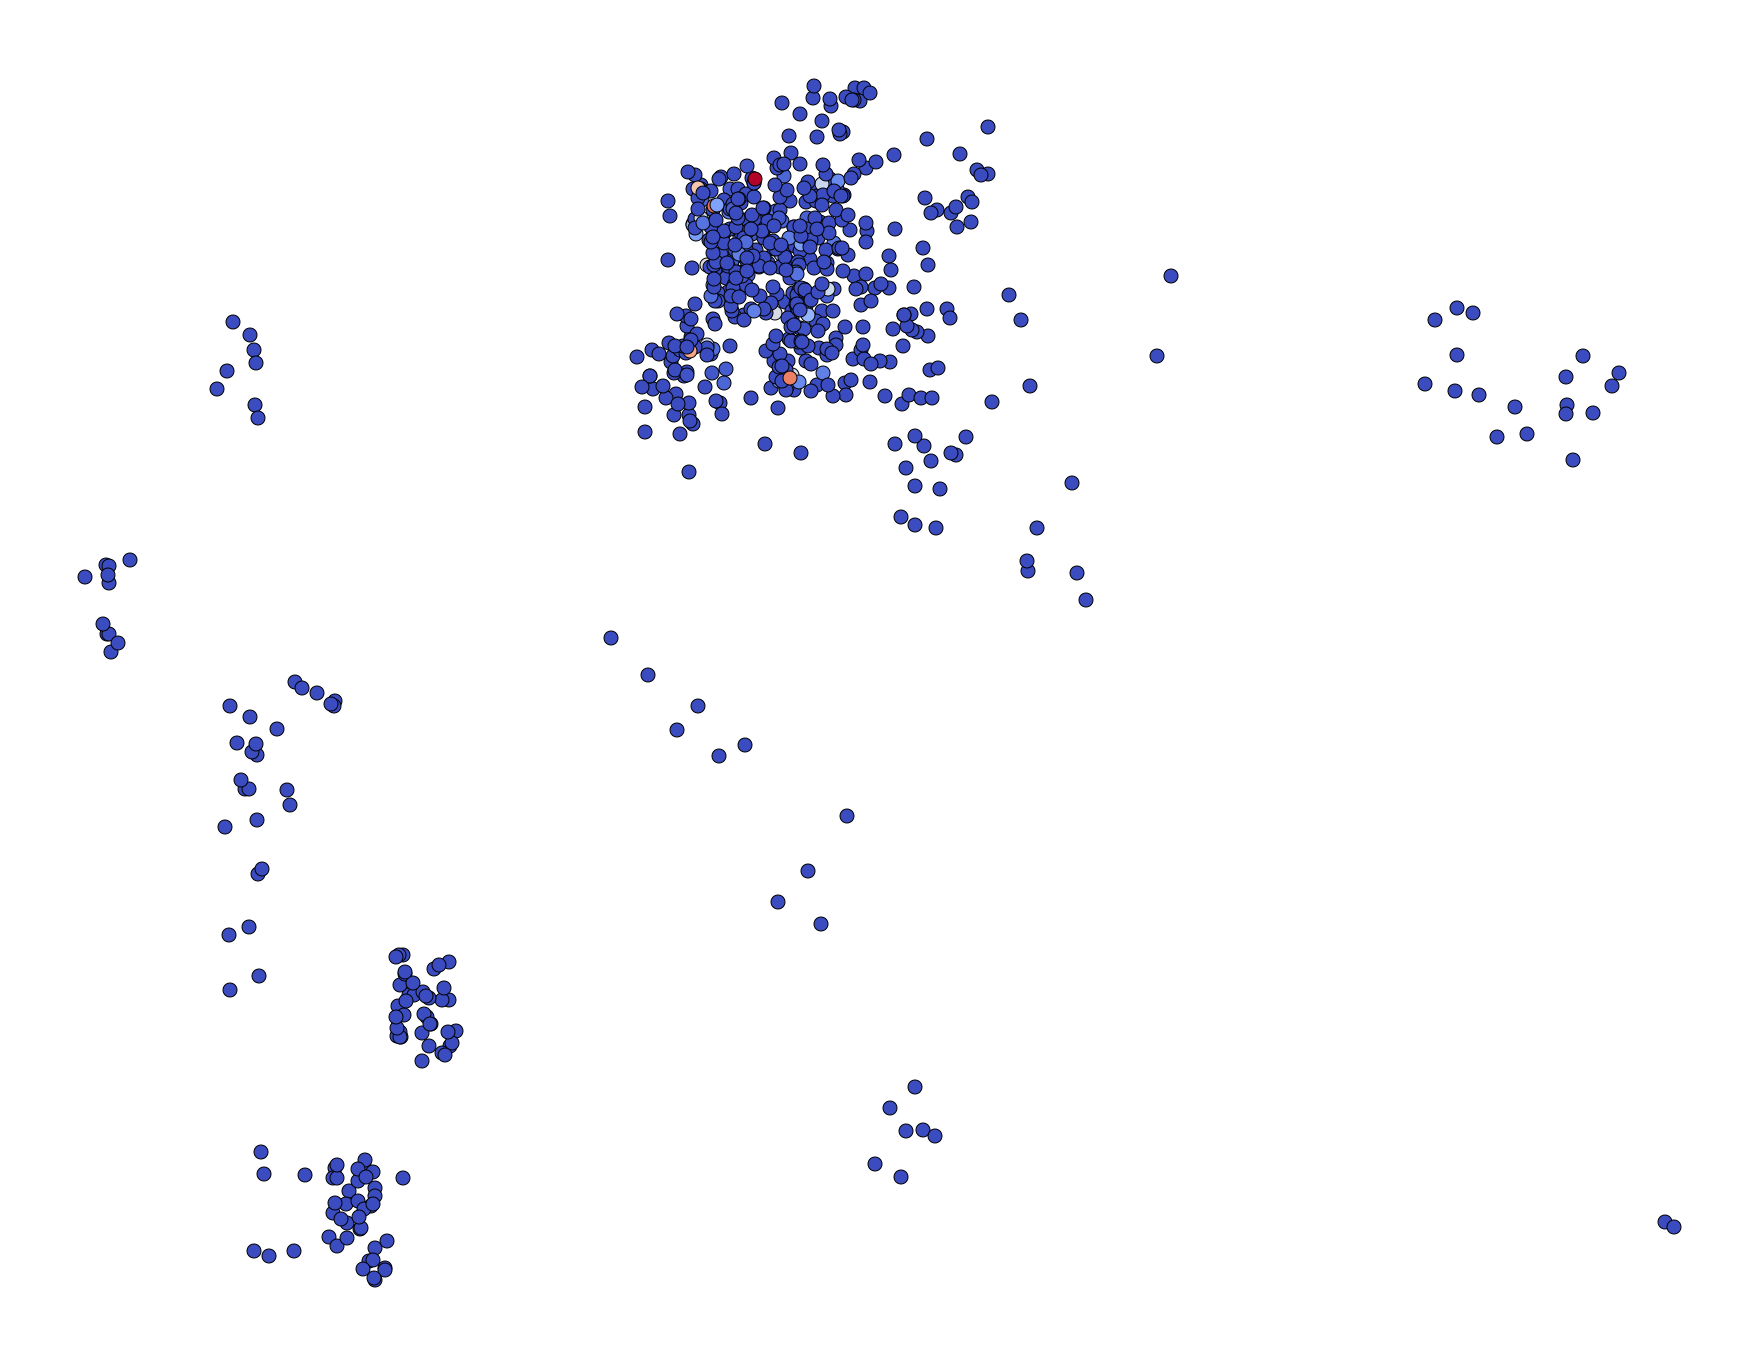

In [19]:
image = svg_graph(adjacency_young, position=geo, display_edges=False, display_edge_weight=False, directed=True, scale=4, display_node_weight=False, edge_width=1, node_size_min=1, name_position='below', scores=scores)
SVG(image)

In [20]:
list_scores = list(scores)
list_best_indexes = []
while (len(list_best_indexes)<=10):
    list_best_indexes.append(np.argmax(list_scores))
    list_scores.pop(np.argmax(list_scores))

In [21]:
best_club_names = []    
for x in list_best_indexes:
    best_club_names.append(dataset.nodes_id_total[x])
print(best_club_names)

['Manchester City', 'Chelsea FC', 'Manchester City U21', 'Juventud de Las Piedras', 'Rayo Vallecano', 'Paradou AC', 'FC Banik Ostrava', 'Liga Muçulmana de Maputo', 'Arsenal FC', 'AS Roma', 'AC Milan']


## Louvain

In [298]:
louvain = skn.clustering.Louvain(resolution=0.8)
labels = louvain.fit_transform(adjacency_young)
labels_unique, counts = np.unique(labels, return_counts=True)

In [299]:
skn.clustering.modularity(adjacency_young, labels)

0.3330080708682338

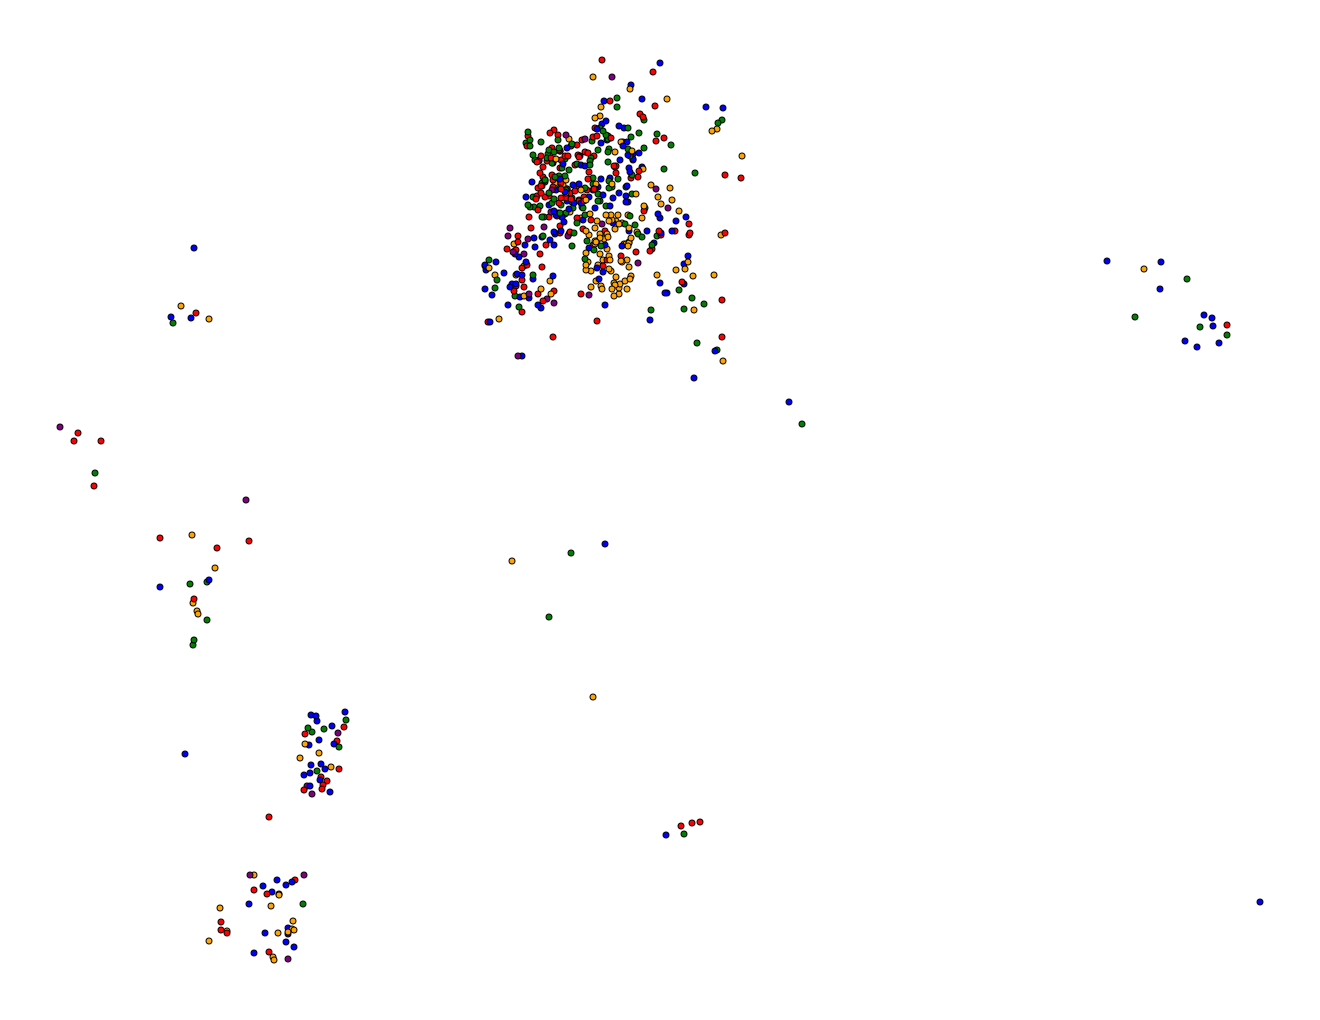

In [300]:
image = svg_graph(adjacency_young, position=geo_young, labels=labels, display_edges=False, display_edge_weight=False, directed=True, node_size=3, scale = 3)
SVG(image)

In [301]:
adjacency_aggregate = louvain.aggregate_
membership = skn.utils.membership_matrix(labels)
averaging = skn.linalg.normalize(membership.T.tocsr()).T
position_aggregate = averaging.T @ geo_young

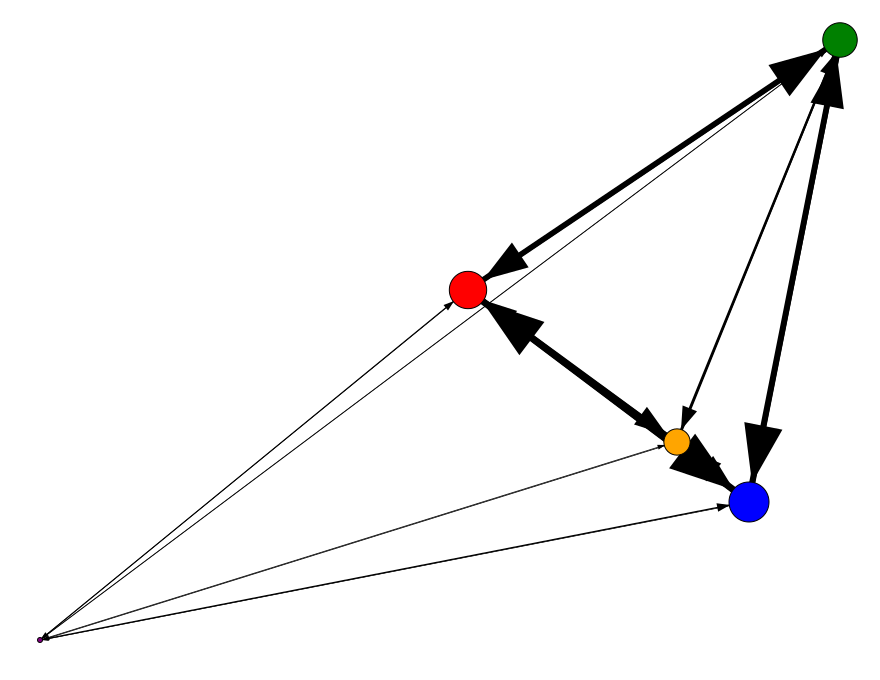

In [302]:
image = svg_graph(adjacency_aggregate, position=position_aggregate, labels=np.arange(len(set(labels))), display_edges=True, display_node_weight=True, directed=True, scale=2)
SVG(image)

In [303]:
vendeurs = adjacency_young.dot(np.ones(len(dataset.nodes_id_young)))
dataset.nodes_id_young[skn.ranking.top_k(vendeurs, 20)]

array(['AS Monaco', 'SL Benfica', 'Borussia Dortmund', 'Ajax Amsterdam',
       'Juventus FC', 'Atlético de Madrid', 'FC Porto', 'LOSC Lille',
       'Olympique Lyon', 'Genoa CFC', 'Red Bull Salzburg',
       'Bayer 04 Leverkusen', 'Inter Milan', 'Atalanta BC', 'Real Madrid',
       'VfB Stuttgart', 'Chelsea FC', 'AS Roma', 'UC Sampdoria',
       'Santos FC'], dtype='<U42')

In [304]:
top_clubs = []
for label in np.unique(labels):
    index = np.argwhere(labels==label).ravel()
    top_clubs.append(index[np.argmax(vendeurs[index])])
top_clubs = np.array(top_clubs)
dataset.nodes_id_young[top_clubs]

array(['AS Monaco', 'Borussia Dortmund', 'Red Bull Salzburg',
       'Juventus FC', 'Villarreal CF'], dtype='<U42')

In [305]:
_, counts = np.unique(labels, return_counts=True)

In [306]:
index = np.argwhere(counts >= 3).ravel()

In [307]:
names = dataset.nodes_id_young[top_clubs][index]

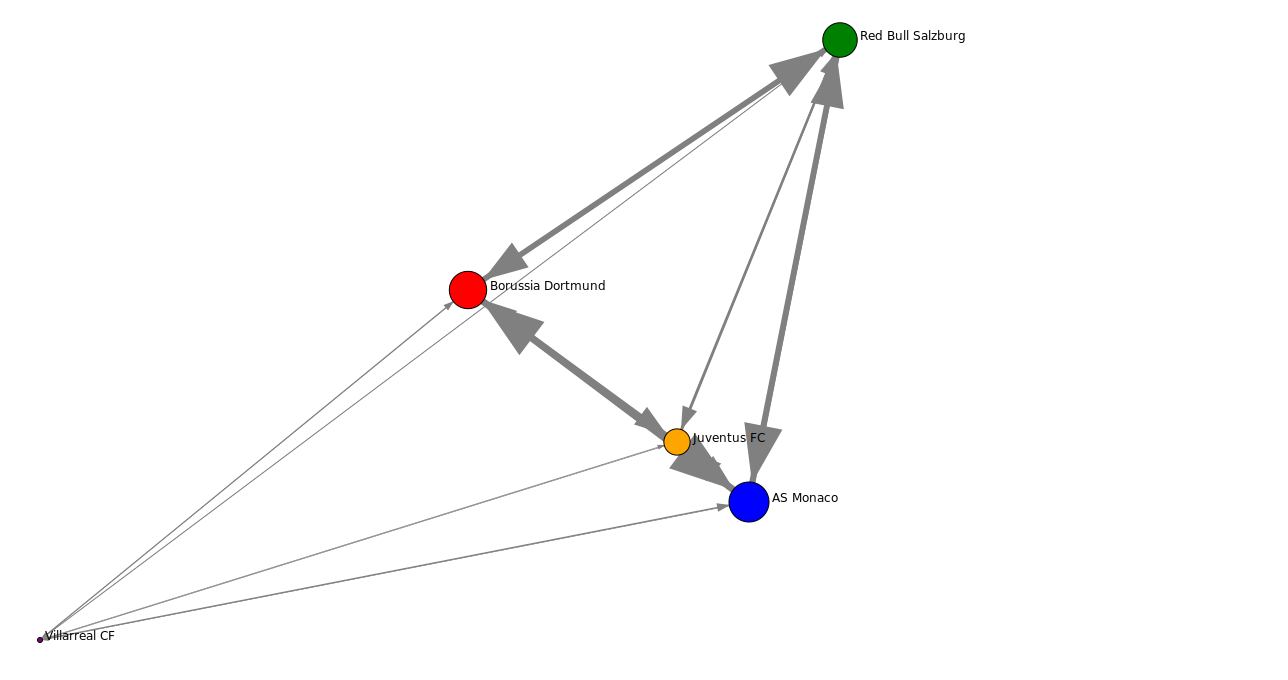

In [308]:
image = svg_graph(adjacency_aggregate[index][:, index], position=position_aggregate[index], labels=index, names=names, display_edges=True, display_node_weight=True, directed=True, scale=2)
SVG(image)

In [309]:
degrees = adjacency_young.dot(np.ones(adjacency_young.shape[0]))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28] [ 7 18 50  3 36 10 26 28 21 10 23  1 27 61 31 18 15 82  6 16 50 13 36 15
  2  1 31 21  4]


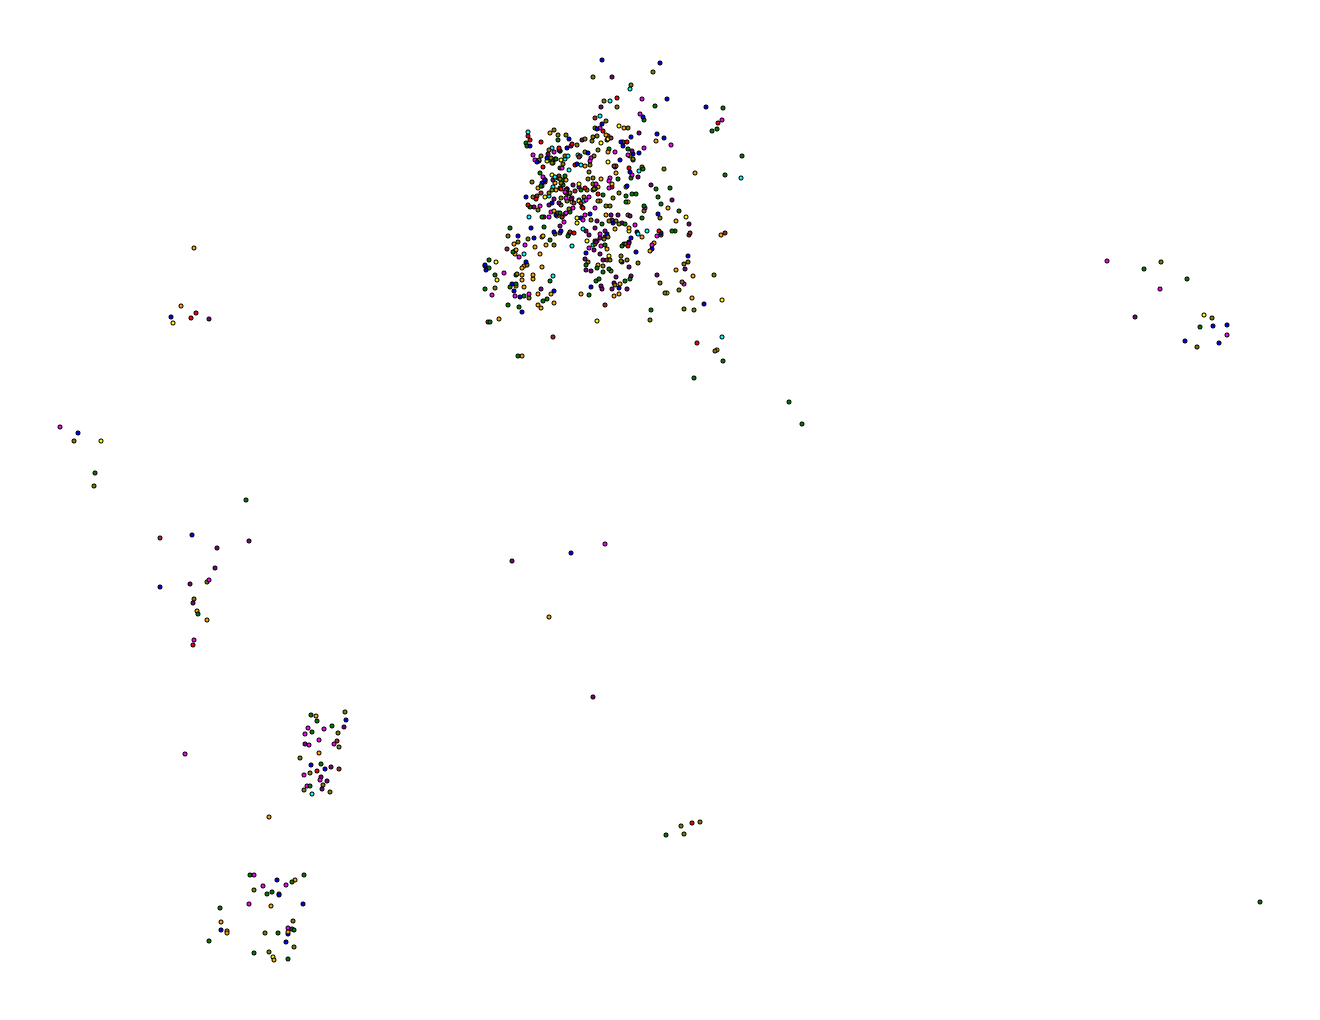

In [310]:
propagation = skn.clustering.PropagationClustering(n_iter=2)
labels = propagation.fit_transform(adjacency_young)
labels_unique, counts = np.unique(labels, return_counts=True)
print(labels_unique, counts)
image = svg_graph(adjacency_young, position=geo_young, labels=labels, display_edges=False, display_edge_weight=False, directed=True, node_size=2, scale=3)
SVG(image)

## Louvain Hierarchical

In [326]:
louvainNE = skn.hierarchy.LouvainHierarchy(n_aggregations=4)
embedding = louvainNE.fit_transform(adjacency_young)

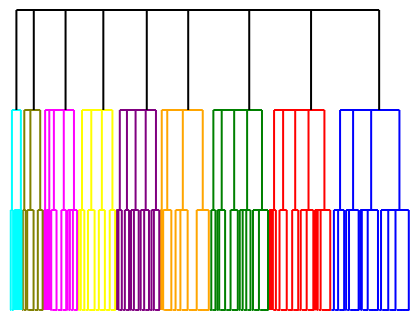

In [331]:
image = skn.visualization.svg_dendrogram(embedding, n_clusters=4)
SVG(image)

## Distances

Another distinct would be the one of a young player trying to reach a top european club. We would try to join the club offering the most possibilities of joining one such club. In order to do so we try to establish distances between clubs.

In [313]:
top_club = ['Liverpool FC', 'Liverpool FC U23','Chelsea FC', 'Chelsea FC U23', 'Manchester City', 'Manchester City U18', 'Manchester City U23', 'Real Madrid', 'Real Madrid Castilla','FC Barcelona', 'FC Barcelona B', 'Bayern Munich', 'FC Bayern Munich II', 'Atlético de Madrid B', 'Atlético de Madrid', 'Juventus FC','Paris Saint-Germain', 'FC Paris Saint-Germain B', 'Juventus U23']
#top_club = ['Liverpool FC','Chelsea FC', 'Manchester City', 'Real Madrid', 'FC Barcelona', 'Bayern Munich', 'Atlético de Madrid', 'Juventus FC','Paris Saint-Germain']

In [314]:
source_list = list(dataset.nodes_id_young.copy())
for i in top_club:
    tmp_index = source_list.index(i)
    source_list.pop(tmp_index)

list_index_sources = []
for i in source_list:
    tmp = list(dataset.nodes_id_young).index(i)
    list_index_sources.append(tmp)
print(list_index_sources)
    
list_index_targets = []
for i in top_club:
    tmp = list(dataset.nodes_id_young).index(i)
    list_index_targets.append(tmp)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 73, 74, 75, 76, 77, 78, 79, 80, 81, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 148, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 2

In [315]:
distances = get_distances(dataset.adjacency_young, list_index_targets , unweighted=True)
distances.T[82]

array([2., 3., 2., 3., 1., 2., 3., 2., 2., 1., 2., 0., 3., 3., 1., 1., 2.,
       3., 2.])

In [316]:
distance_vector = []
max_bound = 7
for i in distances.T:
    if i[0] > 10000:
        distance_vector.append(max_bound)
    elif 0 in i and i[0] <= 10000: 
        distance_vector.append(-1)
    else:
        distance_vector.append(np.mean(i))
        
distance_vector = np.array(distance_vector)

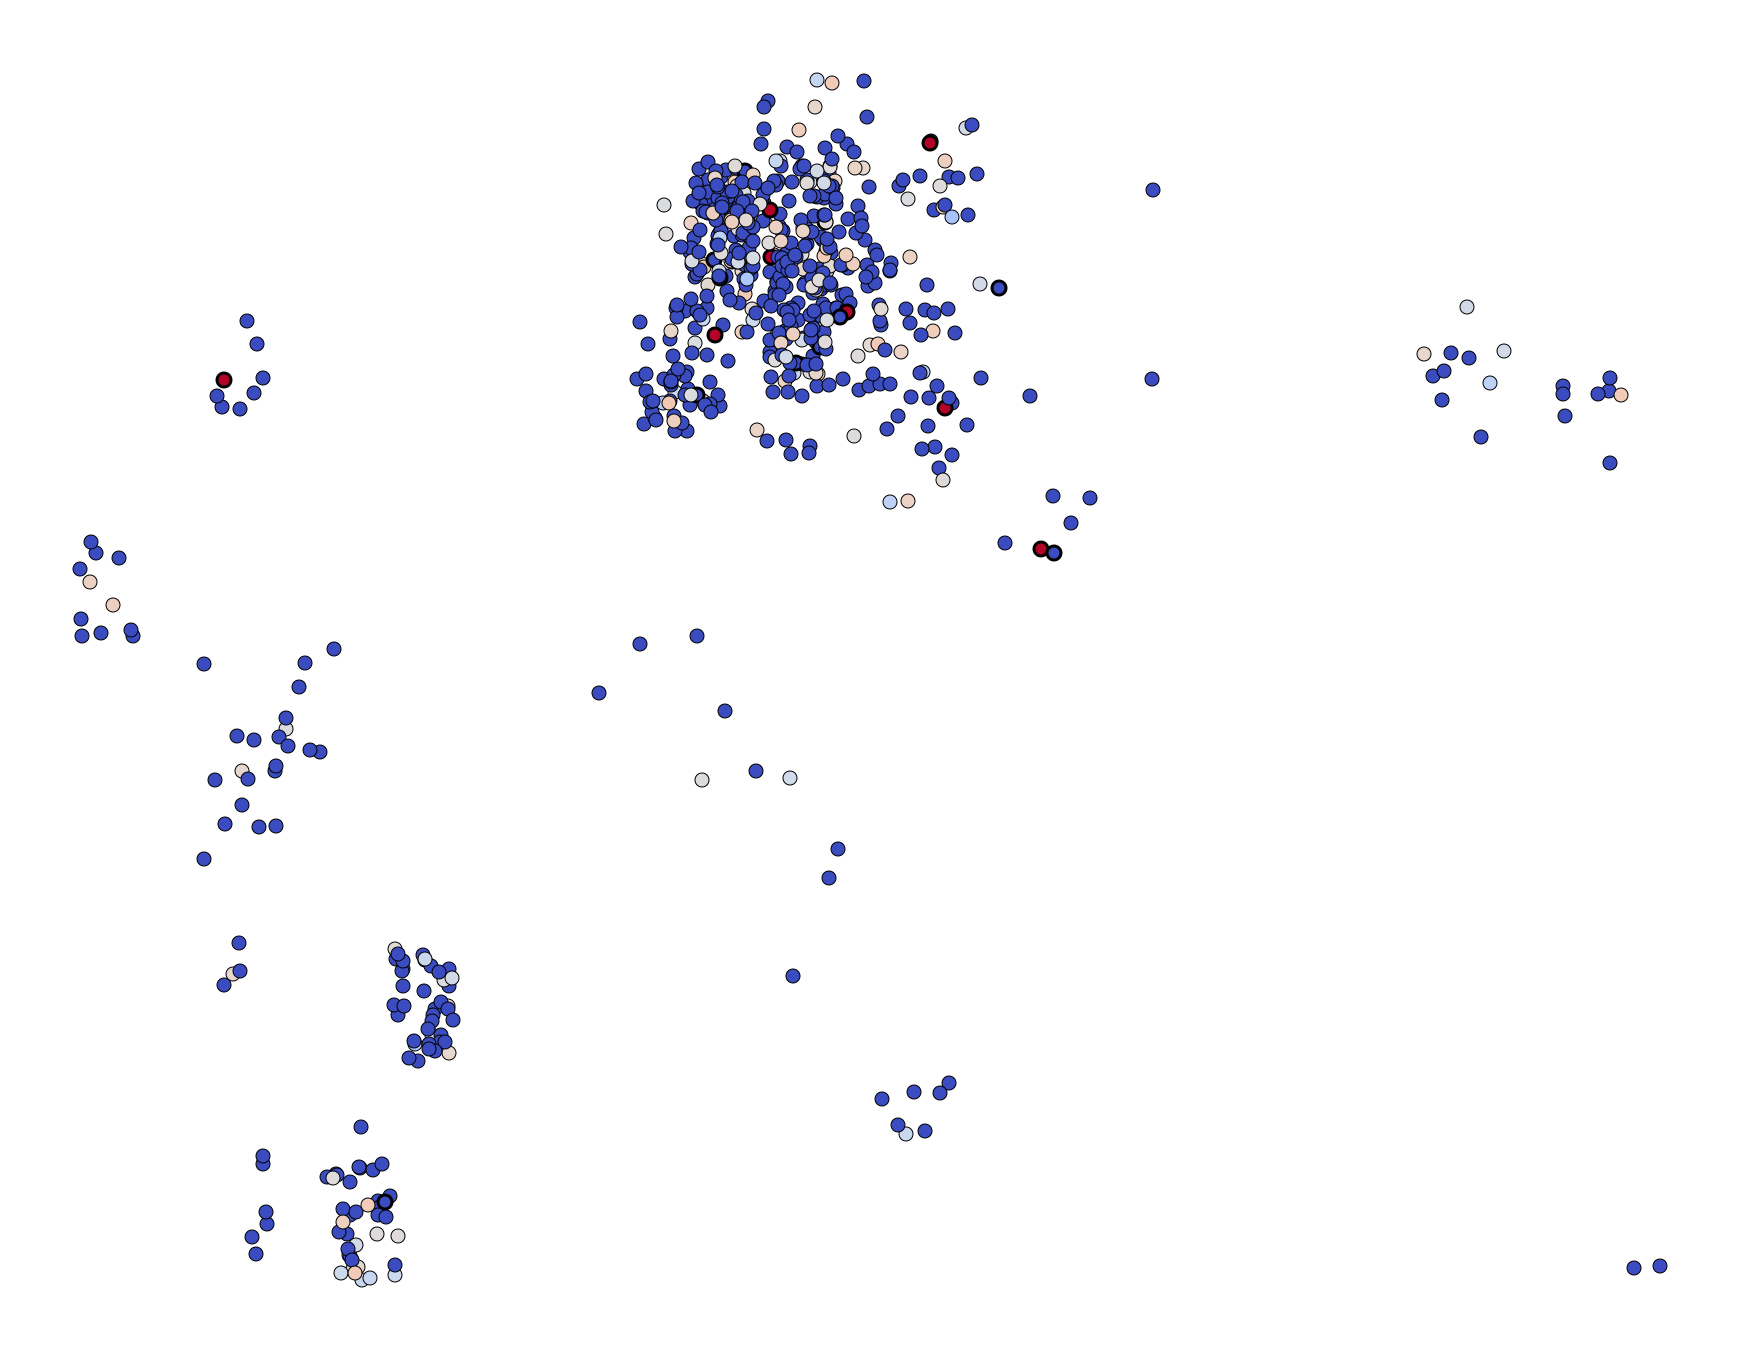

In [317]:
image = svg_graph(dataset.adjacency_young,position=np.array(dataset.geo_total), display_edges=False,display_edge_weight = False, directed=True, scale = 4, display_node_weight= False, edge_width = 1, node_size_min=1, name_position='below', seeds=list_index_targets, scores = -distance_vector)
SVG(image)

In [318]:
distance_vector = list(distance_vector)
better_distance = []
while (len(better_distance)<=1):
    print(np.min(distance_vector))
    if np.min(distance_vector) == -1:
        distance_vector.pop(np.argmin(distance_vector))
    else:    
        better_distance.append(np.argmin(distance_vector))
        distance_vector.pop(np.argmin(distance_vector))
better_distance

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
2.1052631578947367
2.1052631578947367


[91, 409]

In [319]:
best_club_names = []    
for x in better_distance:
    best_club_names.append(dataset.nodes_id_young[x])
print(best_club_names)

['Bologna Primavera', 'MOL Fehérvár FC']
